# Generate optical flow from an image

In [18]:
import os
import datetime
from diffusers import UNet2DModel, DDPMScheduler, DiffusionPipeline
from models.motion_synthesis import VQModel_, generate_spectrum
from utils import *

if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

/home/kpn/anaconda3/envs/tc241/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transforms = FrameSpectrumProcessing(num_freq=16)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.0015, beta_end=0.0195, beta_schedule="scaled_linear")
vae = VQModel_.from_pretrained("data/models/vqvae").to(DEVICE).eval()
unet = UNet2DModel.from_pretrained("data/models/unet").to(DEVICE).eval()

out_dir = "data/unet_samples"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

An error occurred while trying to fetch data/models/vqvae: Error no file named diffusion_pytorch_model.safetensors found in directory data/models/vqvae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [28]:
# Load an image
image_path = "data2/image/0000_0001.png"
frame_np = get_image(image_path, width=256, height=160, crop=True)
frame = transforms.process_frame(frame_np).unsqueeze(0).to(DEVICE)

# Generate motion spectrum
num_steps = 100

sample_name = "_".join([
    os.path.split(image_path)[1],
    "ddpm" + str(num_steps),
    datetime.datetime.now().isoformat().replace(":", "_")
])

spec_np = generate_spectrum(vae, unet, noise_scheduler, frame, num_steps=num_steps, batch_size=1)

path = os.path.join(out_dir, sample_name + ".npy")
save_npy(spec_np, path)
print(f"sample saved at {path}")

# Visualize the result
spec_image, video = visualize_sample(frame_np, spec_np, transforms, magnification=5.0, include_flow=True)

path = os.path.join(out_dir, sample_name + ".png")
spec_image.save(path)
print(f"spectrum image saved at {path}")

path = os.path.join(out_dir, sample_name + ".mp4")
video.write_videofile(path, logger=None)
print(f"video saved at {path}")

100%|██████████| 16/16 [00:34<00:00,  2.18s/it]


sample saved at data/unet_samples/512px-001_2015_04_19_Das_Gelb_der_Natur.jpg_ddpm100_2024-09-19T21_47_25.495039.npy
spectrum image saved at data/unet_samples/512px-001_2015_04_19_Das_Gelb_der_Natur.jpg_ddpm100_2024-09-19T21_47_25.495039.png
video saved at data/unet_samples/512px-001_2015_04_19_Das_Gelb_der_Natur.jpg_ddpm100_2024-09-19T21_47_25.495039.mp4


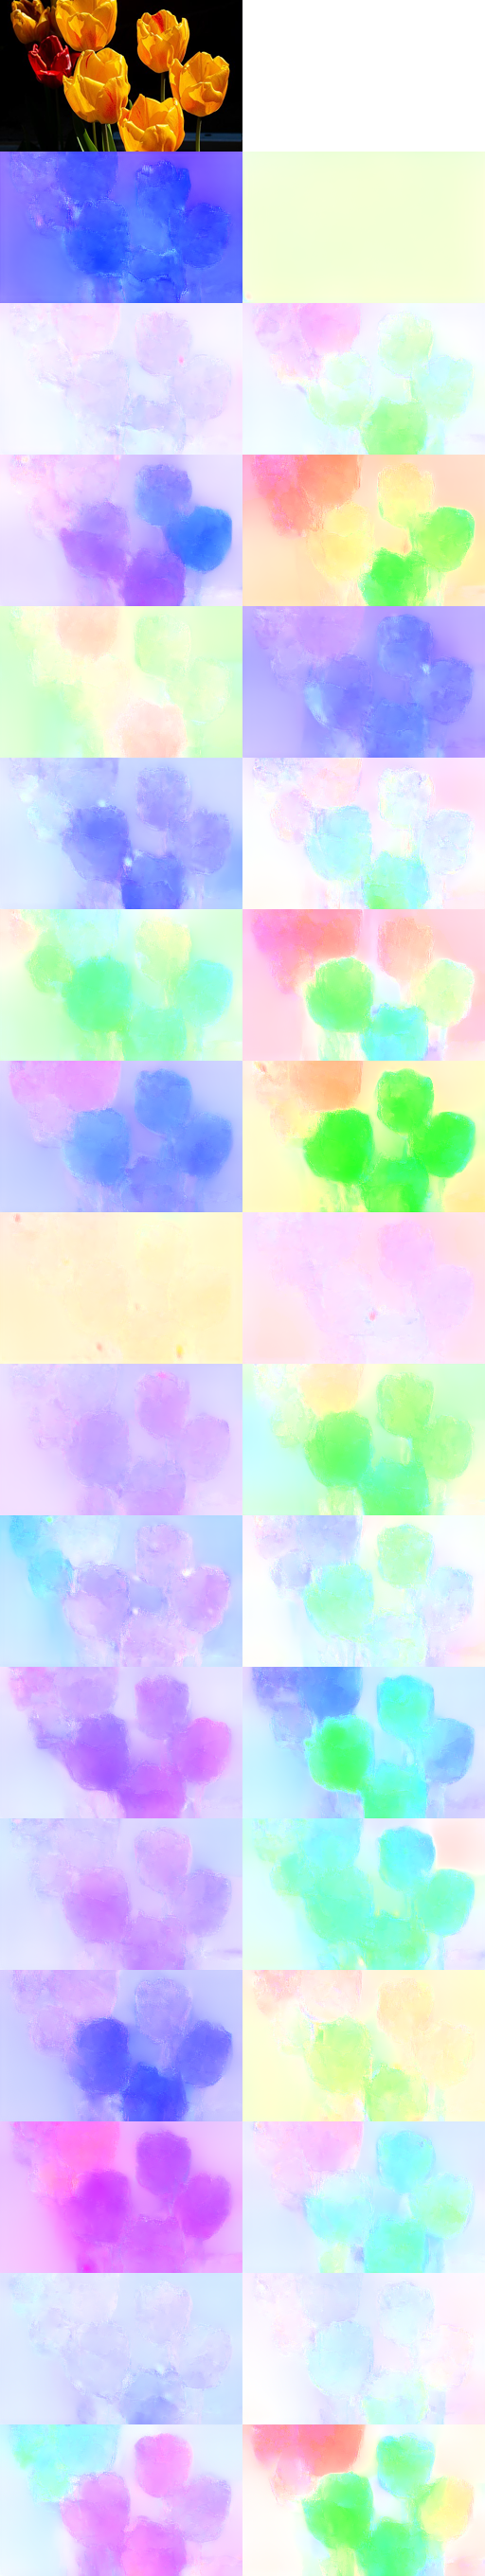

In [29]:
# Show generated FFT in an image. Each row shows a frequency with the real part on the left and the imaginary part on the right.
spec_image

In [30]:
# Show optical flow derived from generated spectrum and warped frames
video.ipython_display(loop=1, autoplay=1, rd_kwargs=dict(logger=None))

In [ ]:
# Reconstruct the video from the first frame and optical flow
src_frame = transforms.process_frame(frames[0]).unsqueeze(0).to(DEVICE)
flow = transforms.process_flow(flow).to(DEVICE)

In [ ]:
pred = predict_tensor(src_frame.double(), flow, model.double(), transforms, return_tensor=False)

clip = mpy.ImageSequenceClip(list(np.concatenate([
    add_video_title(frames[1:], "Original frames"),
    add_video_title(pred, "Model prediction")
], axis=2)), fps=30)
clip.ipython_display(loop=1, autoplay=1, rd_kwargs=dict(logger=None))

# Generate video from image and optical flow

In [1]:
import sys
sys.path.append('D:/py_libs')

In [2]:
import datetime
import moviepy.editor as mpy
from models.frame_synthesis import *
from utils import *
from utils.flow import optical_flow
DEVICE = torch.device("cuda:0")

model = Synthesis()
model.load_state_dict(torch.load("data/models/frame_synthesis.pth")["model"])
model = model.to(DEVICE).eval()

transforms = FrameFlowProcessing()

In [ ]:
# Load a 5-second frame sequence
video_path = "data2/video/0000_0001.mp4"
start_sec = 5
fps = 30
num_frames = 150

frames = get_frames(video_path, w=256, h=160, start_sec=start_sec, fps=fps, f=num_frames)

# Show the sequence
clip = mpy.ImageSequenceClip(list(frames), fps=fps)
clip.ipython_display(loop=1, autoplay=1, rd_kwargs=dict(logger=None))

In [ ]:
# Estimate optical flow from the first frame to each frame
start_time = datetime.datetime.now()
flow = optical_flow(frames[0], frames[1:])
print(datetime.datetime.now() - start_time)

In [ ]:
# Visualize optical flow
flow_color = flow_to_color_video(flow)

clip = mpy.ImageSequenceClip(list(flow_color), fps=30)
clip.ipython_display(loop=1, autoplay=1, rd_kwargs=dict(logger=None))

In [ ]:
pred = predict_tensor(src_frame.double(), flow, model.double(), transforms, return_tensor=False)

clip = mpy.ImageSequenceClip(list(np.concatenate([
    add_video_title(frames[1:], "Original frames"),
    add_video_title(pred, "Model prediction")
], axis=2)), fps=30)
clip.ipython_display(loop=1, autoplay=1, rd_kwargs=dict(logger=None))

In [18]:
!pip install diffusers
from diffusers import DiffusionPipeline

model_id = "CompVis/ldm-celebahq-256"

# load model and scheduler
pipeline = DiffusionPipeline.from_pretrained(model_id)

# run pipeline in inference (sample random noise and denoise)
image = pipeline(num_inference_steps=200)["sample"]

# save image
image[0].save("ldm_generated_image.png")


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


Couldn't connect to the Hub: (MaxRetryError("HTTPSConnectionPool(host='hf-mirror.comexport', port=443): Max retries exceeded with url: /api/models/CompVis/ldm-celebahq-256 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7ff33c2673d0>: Failed to establish a new connection: [Errno 111] Connection refused'))"), '(Request ID: ef1cc00e-130b-48d1-abae-aa2bdc7c2e8f)').
Will try to load from local cache.


OSError: Cannot load model CompVis/ldm-celebahq-256: model is not cached locally and an error occurred while trying to fetch metadata from the Hub. Please check out the root cause in the stacktrace above.